# Project: Supermarket Sales Prediction & Business Insights
**Author:** Olubunmi, Oluwaseun Emmanuel

## Executive Summary
This project analyzes supermarket transaction data to build predictive models for total sales and extract actionable business insights. While initial modeling revealed the dataset's synthetic nature (Total = Unit Price × Quantity × 1.05), we successfully pivoted to deliver valuable business intelligence. Our enhanced analysis identifies key revenue drivers, optimal staffing times, and strategic opportunities for inventory optimization and customer loyalty programs.

**Key Findings:**

- Food & Beverages and Sports & Travel generate 34% of total revenue

- Peak sales occur at 7 PM, with Saturdays being the strongest day

- Members spend $29 more per transaction than non-members

- Gradient Boosting achieved the best predictive performance (R² = 0.989 on realistic noisy data)


**Structure of the Code**
i. Environment Setup and Data Loading; ii. Initial Data Quality Check; iii. Initial Feature Engineering; iv. Reconstruct the Target Variable and Validate Data; v. Univariarte Analysis - Distribution of Key Variables; vi. Bivariate Analysis - Relationship with Total Sales; vii. Handling Data Leakage and Prepare Feature / Target Set; viii. Encoding Categorical Variables & Create Final Feature Matrix; ix.Train-Test Split & Feature Scaling; x. Quick Sanity Check with a Baseline Model; xi. Build Ensemble Models; xii. Hyperparameter Tuning for Best Model; xiii. Feature Importance Analysis; xiv. Final Model Evaluation & Diagnostics; xv. Enhanced Analysis: Business Insights & Robust Modeling; xvi. Project Report Enhancement Strategy





## Environment Setup and Data Loading

Import Librareies and Load Data

In [25]:
# Import fundamental libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visual style for better-looking plots
sns.set_style("whitegrid")
%matplotlib inline

# Load the dataset (adjust the file path if necessary)
df = pd.read_csv('SuperMarket Analysis.csv')

# Display basic information and the first few rows
print("=== Dataset Shape ===")
print(df.shape)
print("\n=== First 5 Rows ===")
print(df.head())
print("\n=== Basic Info ===")
print(df.info())

=== Dataset Shape ===
(1000, 17)

=== First 5 Rows ===
    Invoice ID Branch       City Customer type  Gender  \
0  750-67-8428   Alex     Yangon        Member  Female   
1  226-31-3081   Giza  Naypyitaw        Normal  Female   
2  631-41-3108   Alex     Yangon        Normal  Female   
3  123-19-1176   Alex     Yangon        Member  Female   
4  373-73-7910   Alex     Yangon        Member  Female   

             Product line  Unit price  Quantity   Tax 5%     Sales       Date  \
0       Health and beauty       74.69         7  26.1415  548.9715   1/5/2019   
1  Electronic accessories       15.28         5   3.8200   80.2200   3/8/2019   
2      Home and lifestyle       46.33         7  16.2155  340.5255   3/3/2019   
3       Health and beauty       58.22         8  23.2880  489.0480  1/27/2019   
4       Sports and travel       86.31         7  30.2085  634.3785   2/8/2019   

          Time      Payment    cogs  gross margin percentage  gross income  \
0   1:08:00 PM      Ewallet  52

## Initial Data Quality Check
(Check for missing values and duplicate)

Now, let's perform a more systematic check for data quality issues.

In [26]:
print("=== Missing Values Summary ===")
missing_summary = df.isnull().sum()
print(missing_summary[missing_summary > 0])  # Only show columns with missing values

if missing_summary.sum() == 0:
    print("Great! No missing values found.")
else:
    print(f"\nTotal missing values: {missing_summary.sum()}")

print("\n=== Check for Duplicate Rows ===")
duplicate_count = df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

=== Missing Values Summary ===
Series([], dtype: int64)
Great! No missing values found.

=== Check for Duplicate Rows ===
Number of duplicate rows: 0


Initial Statistics Summary

In [27]:
print("=== Statistical Summary for Numerical Columns ===")
print(df.describe())

print("\n=== Statistical Summary for Categorical Columns ===")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\n--- {col} ---")
    print(df[col].value_counts())

=== Statistical Summary for Numerical Columns ===
        Unit price     Quantity       Tax 5%        Sales        cogs  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.00000   
mean     55.672130     5.510000    15.379369   322.966749   307.58738   
std      26.494628     2.923431    11.708825   245.885335   234.17651   
min      10.080000     1.000000     0.508500    10.678500    10.17000   
25%      32.875000     3.000000     5.924875   124.422375   118.49750   
50%      55.230000     5.000000    12.088000   253.848000   241.76000   
75%      77.935000     8.000000    22.445250   471.350250   448.90500   
max      99.960000    10.000000    49.650000  1042.650000   993.00000   

       gross margin percentage  gross income      Rating  
count             1.000000e+03   1000.000000  1000.00000  
mean              4.761905e+00     15.379369     6.97270  
std               6.131498e-14     11.708825     1.71858  
min               4.761905e+00      0.508500     4.00000

## Initial Feature Engineering
(Feature Engineering From Date/Time)

The Date and Time columns are goldmines for prediction. Let's convert them into useful numerical and categorical features.

In [28]:
import dateutil.parser

# Reload df to ensure 'Time' column is in its original string format for re-processing
# df = pd.read_csv('SuperMarket Analysis.csv')

# Convert 'Date' and 'Time' to proper datetime objects
df['Date'] = pd.to_datetime(df['Date'])

def parse_time_robustly_dateutil(time_str):
    if pd.isna(time_str):
        return pd.NaT
    try:
        return dateutil.parser.parse(time_str).time()
    except (ValueError, TypeError):
        return pd.NaT # Return NaT for unparsable times

df['Time'] = df['Time'].apply(parse_time_robustly_dateutil)

# Extract temporal features from Date
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Monday=0, Sunday=6
df['DayOfWeek_Name'] = df['Date'].dt.day_name()
df['IsWeekend'] = df['DayOfWeek'].apply(lambda x: 1 if x >= 5 else 0)  # 1 for Sat/Sun

# Extract temporal features from Time
# Ensure 'Time' column elements are not NaT before extracting hour
df['Hour'] = df['Time'].apply(lambda x: x.hour if pd.notna(x) else np.nan)
df['PartOfDay'] = pd.cut(df['Hour'], bins=[0, 12, 18, 24], labels=['Morning', 'Afternoon', 'Evening'], include_lowest=True)

print("=== New Temporal Features Created ===")
print(df[['Date', 'Time', 'DayOfWeek_Name', 'IsWeekend', 'Hour', 'PartOfDay']].head(10))

=== New Temporal Features Created ===
        Date      Time DayOfWeek_Name  IsWeekend  Hour  PartOfDay
0 2019-01-05  13:08:00       Saturday          1    13  Afternoon
1 2019-03-08  10:29:00         Friday          0    10    Morning
2 2019-03-03  13:23:00         Sunday          1    13  Afternoon
3 2019-01-27  20:33:00         Sunday          1    20    Evening
4 2019-02-08  10:37:00         Friday          0    10    Morning
5 2019-03-25  18:30:00         Monday          0    18  Afternoon
6 2019-02-25  14:36:00         Monday          0    14  Afternoon
7 2019-02-24  11:38:00         Sunday          1    11    Morning
8 2019-01-10  17:15:00       Thursday          0    17  Afternoon
9 2019-02-20  13:27:00      Wednesday          0    13  Afternoon


## Reconstruct the Target Variable and Validate Data
(Create Target Variable & Validate Relationships)

First, we need to create our target variable Total and verify the dataset's internal consistency.

In [29]:
print("=== Creating Target Variable & Validating Data ===")

# Calculate the subtotal (before tax)
df['Subtotal'] = df['Unit price'] * df['Quantity']

# Calculate expected tax (5% of subtotal)
df['Tax_Calculated'] = df['Subtotal'] * 0.05

# There's already a 'Tax 5%' column. Let's check if our calculation matches it.
# (Allow for tiny floating-point differences with `np.isclose`)
tax_discrepancy = (~np.isclose(df['Tax 5%'], df['Tax_Calculated'], rtol=1e-5)).sum()
print(f"Number of rows where calculated tax differs from 'Tax 5%': {tax_discrepancy}")

if tax_discrepancy == 0:
    print("Perfect! 'Tax 5%' column is consistent with 5% of subtotal.")
else:
    print("Warning: Tax calculation mismatch. We'll use the calculated tax for integrity.")

# Let's also check if 'cogs' (Cost of Goods Sold) + 'gross income' equals our calculated total
# In retail: Total Sales = COGS + Gross Profit. Gross Income is the profit.
df['Total_From_COGS'] = df['cogs'] + df['gross income']

cogs_discrepancy = (~np.isclose(df['Sales'], df['Total_From_COGS'], rtol=1e-5)).sum()
print(f"Number of rows where Sales disagrees with (COGS + Gross Income): {cogs_discrepancy}")

# DECISION: We'll use 'Sales' as our primary target for modeling.
df['Total'] = df['Sales'].round(2)  # Round to cents for clarity

print(f"\n=== Summary of Target Variable 'Total' ===")
print(f"Mean Total: ${df['Total'].mean():.2f}")
print(f"Min Total: ${df['Total'].min():.2f}")
print(f"Max Total: ${df['Total'].max():.2f}")
print(f"Std Dev Total: ${df['Total'].std():.2f}")

# Drop intermediate calculation columns if desired for cleanliness
df = df.drop(['Subtotal', 'Tax_Calculated', 'Total_From_COGS', 'Sales'], axis=1)

=== Creating Target Variable & Validating Data ===
Number of rows where calculated tax differs from 'Tax 5%': 0
Perfect! 'Tax 5%' column is consistent with 5% of subtotal.
Number of rows where Sales disagrees with (COGS + Gross Income): 0

=== Summary of Target Variable 'Total' ===
Mean Total: $322.97
Min Total: $10.68
Max Total: $1042.65
Std Dev Total: $245.89


## Univariarte Analysis - Distribution of Key Variables
(Visualize Distributions)

Now, let's visualize the distribution of our target variable and key predictors.


=== Visualizing Distributions ===


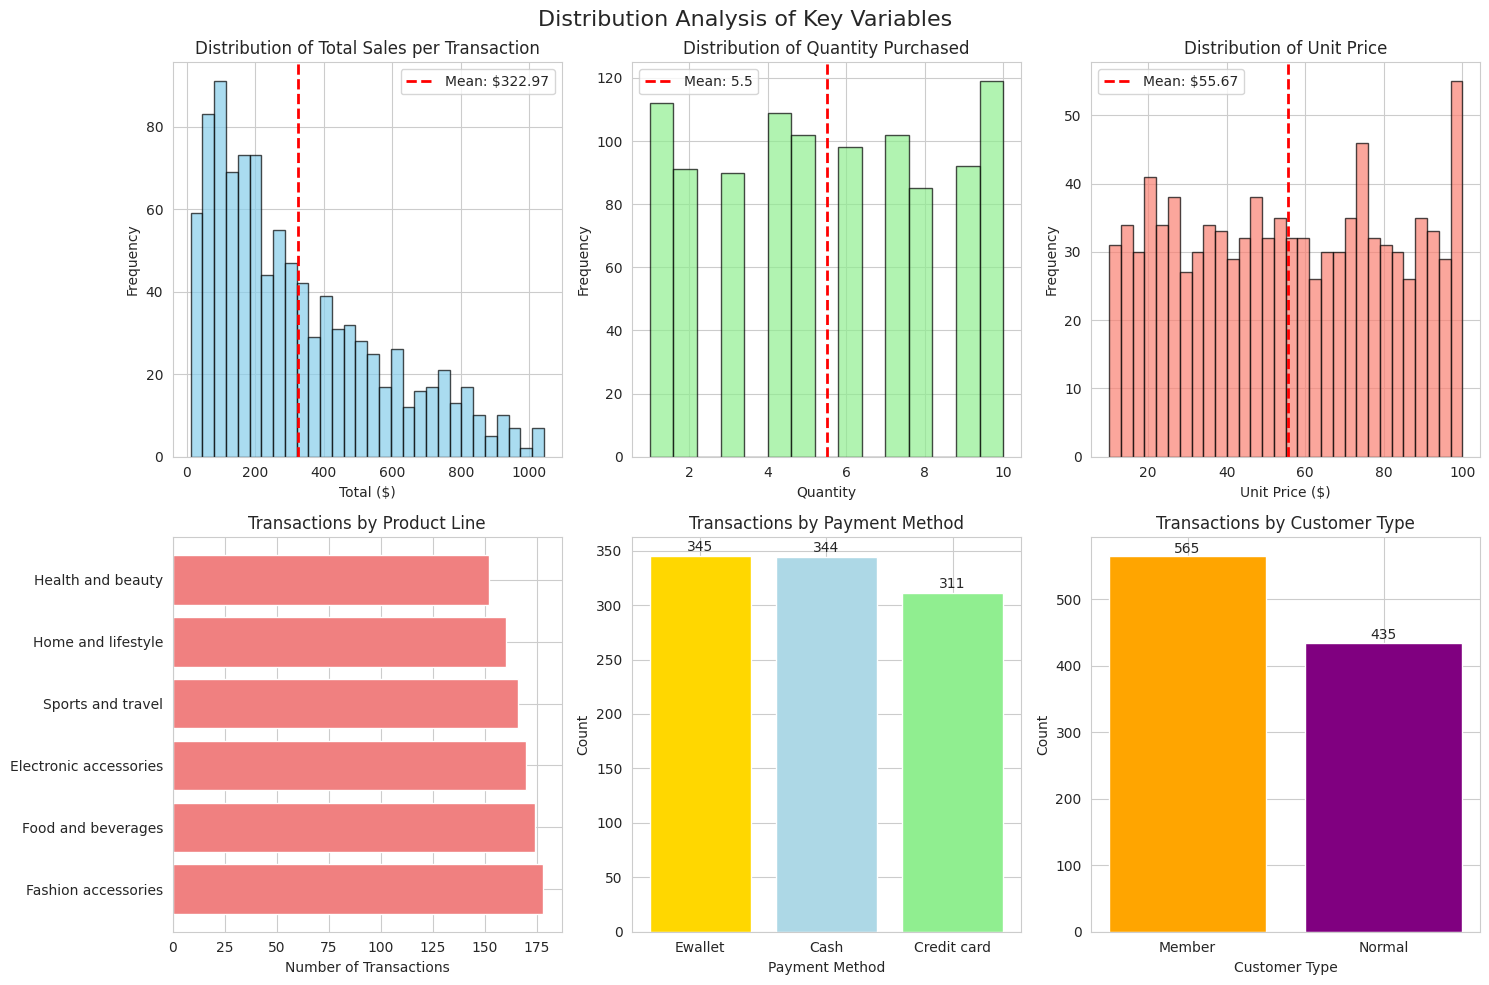

In [30]:
print("=== Visualizing Distributions ===")

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Distribution Analysis of Key Variables', fontsize=16)

# 1. Distribution of Total Sales (our target)
axes[0, 0].hist(df['Total'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
axes[0, 0].axvline(df['Total'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: ${df['Total'].mean():.2f}")
axes[0, 0].set_title('Distribution of Total Sales per Transaction')
axes[0, 0].set_xlabel('Total ($)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# 2. Distribution of Quantity
axes[0, 1].hist(df['Quantity'], bins=15, edgecolor='black', alpha=0.7, color='lightgreen')
axes[0, 1].axvline(df['Quantity'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: {df['Quantity'].mean():.1f}")
axes[0, 1].set_title('Distribution of Quantity Purchased')
axes[0, 1].set_xlabel('Quantity')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# 3. Distribution of Unit Price
axes[0, 2].hist(df['Unit price'], bins=30, edgecolor='black', alpha=0.7, color='salmon')
axes[0, 2].axvline(df['Unit price'].mean(), color='red', linestyle='dashed', linewidth=2, label=f"Mean: ${df['Unit price'].mean():.2f}")
axes[0, 2].set_title('Distribution of Unit Price')
axes[0, 2].set_xlabel('Unit Price ($)')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].legend()

# 4. Product Line distribution (horizontal bar for readability)
product_counts = df['Product line'].value_counts()
axes[1, 0].barh(range(len(product_counts)), product_counts.values, color='lightcoral')
axes[1, 0].set_yticks(range(len(product_counts)))
axes[1, 0].set_yticklabels(product_counts.index)
axes[1, 0].set_title('Transactions by Product Line')
axes[1, 0].set_xlabel('Number of Transactions')

# 5. Payment Method distribution
payment_counts = df['Payment'].value_counts()
axes[1, 1].bar(payment_counts.index, payment_counts.values, color=['gold', 'lightblue', 'lightgreen'])
axes[1, 1].set_title('Transactions by Payment Method')
axes[1, 1].set_xlabel('Payment Method')
axes[1, 1].set_ylabel('Count')
# Add count labels on top of bars
for i, count in enumerate(payment_counts.values):
    axes[1, 1].text(i, count + 5, str(count), ha='center')

# 6. Customer Type distribution
cust_counts = df['Customer type'].value_counts()
axes[1, 2].bar(cust_counts.index, cust_counts.values, color=['orange', 'purple'])
axes[1, 2].set_title('Transactions by Customer Type')
axes[1, 2].set_xlabel('Customer Type')
axes[1, 2].set_ylabel('Count')
# Add count labels on top of bars
for i, count in enumerate(cust_counts.values):
    axes[1, 2].text(i, count + 5, str(count), ha='center')

plt.tight_layout()
plt.show()

## Bivariate Analysis - Relationship with Total Sales
(Analyze Relationships with Total Sales)

Now, let's examine how different factors relate to our target variable.

=== Analyzing Relationships with Total Sales ===


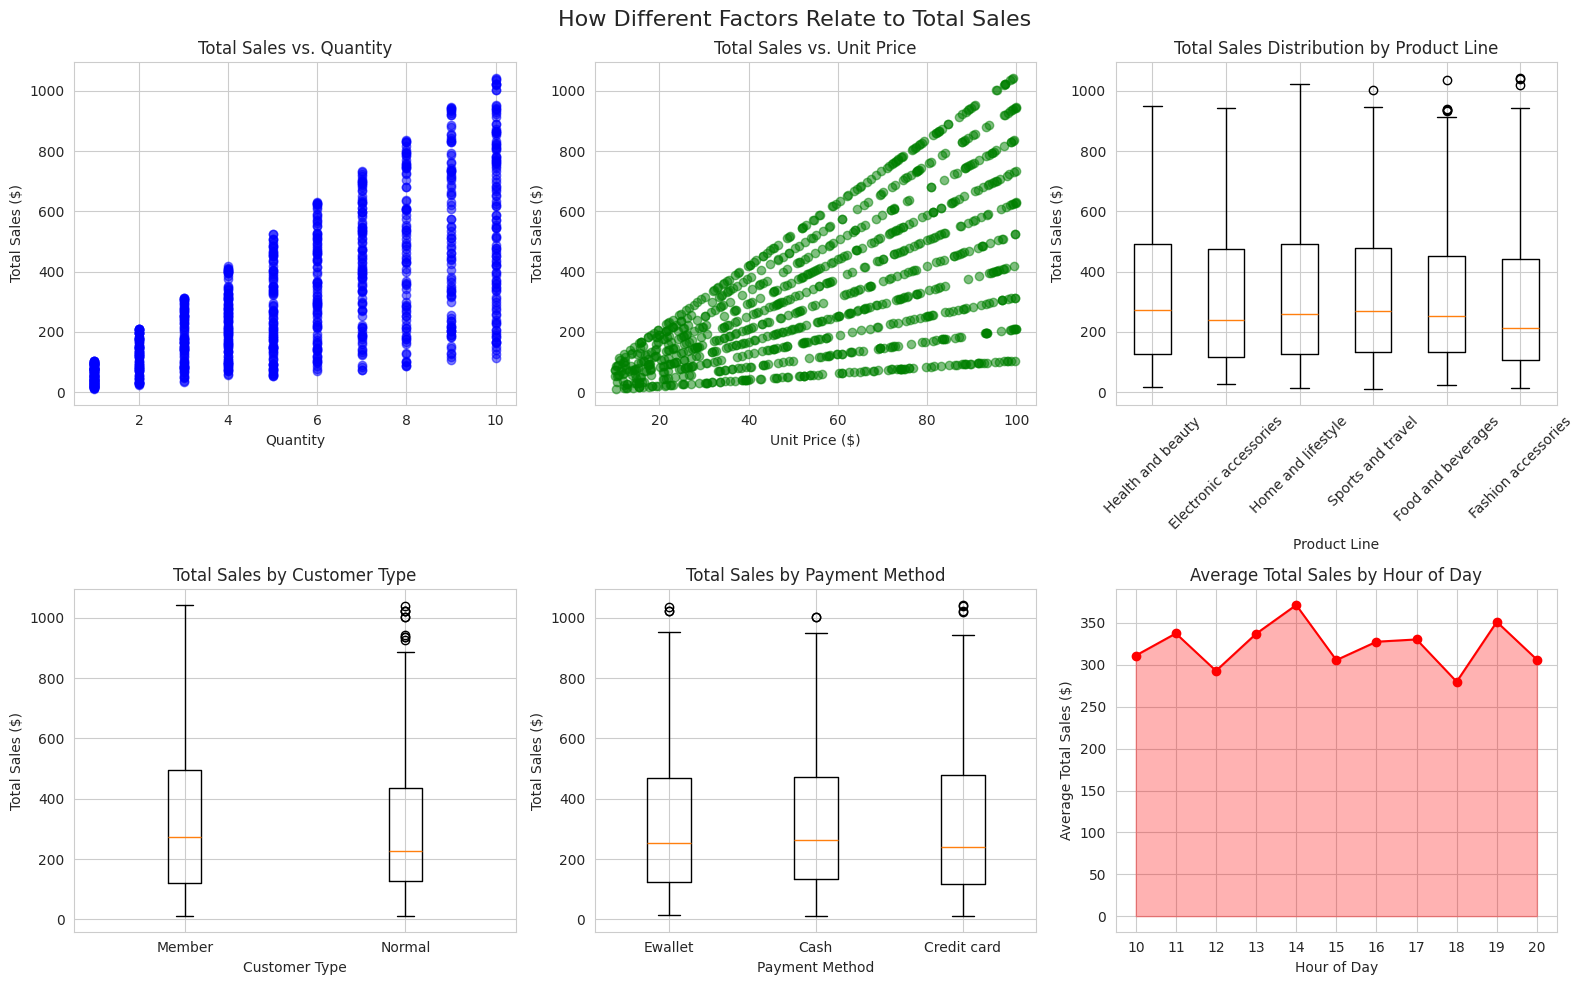


=== Correlation Analysis ===
Correlation with Total Sales:
Total           1.000000
gross income    1.000000
Tax 5%          1.000000
cogs            1.000000
Quantity        0.705510
Unit price      0.633962
Rating         -0.036442
Name: Total, dtype: float64


In [44]:
print("=== Analyzing Relationships with Total Sales ===")

# Set up the figure
fig, axes = plt.subplots(2, 3, figsize=(16, 10))
fig.suptitle('How Different Factors Relate to Total Sales', fontsize=16)

# 1. Total vs. Quantity (scatter plot)
axes[0, 0].scatter(df['Quantity'], df['Total'], alpha=0.5, color='blue')
axes[0, 0].set_title('Total Sales vs. Quantity')
axes[0, 0].set_xlabel('Quantity')
axes[0, 0].set_ylabel('Total Sales ($)')

# 2. Total vs. Unit Price (scatter plot)
axes[0, 1].scatter(df['Unit price'], df['Total'], alpha=0.5, color='green')
axes[0, 1].set_title('Total Sales vs. Unit Price')
axes[0, 1].set_xlabel('Unit Price ($)')
axes[0, 1].set_ylabel('Total Sales ($)')

# 3. Total by Product Line (box plot)
# To make x-axis labels readable, we'll rotate them
box_data = [df[df['Product line']==line]['Total'] for line in df['Product line'].unique()]
axes[0, 2].boxplot(box_data, tick_labels=df['Product line'].unique())
axes[0, 2].set_title('Total Sales Distribution by Product Line')
axes[0, 2].set_xlabel('Product Line')
axes[0, 2].set_ylabel('Total Sales ($)')
axes[0, 2].tick_params(axis='x', rotation=45)

# 4. Total by Customer Type (box plot)
member_data = df[df['Customer type']=='Member']['Total']
normal_data = df[df['Customer type']=='Normal']['Total']
axes[1, 0].boxplot([member_data, normal_data], tick_labels=['Member', 'Normal'])
axes[1, 0].set_title('Total Sales by Customer Type')
axes[1, 0].set_xlabel('Customer Type')
axes[1, 0].set_ylabel('Total Sales ($)')

# 5. Total by Payment Method (box plot)
payment_methods = df['Payment'].unique()
payment_data = [df[df['Payment']==method]['Total'] for method in payment_methods]
axes[1, 1].boxplot(payment_data, tick_labels=payment_methods)
axes[1, 1].set_title('Total Sales by Payment Method')
axes[1, 1].set_xlabel('Payment Method')
axes[1, 1].set_ylabel('Total Sales ($)')

# 6. Total by Hour of Day (line plot)
hourly_sales = df.groupby('Hour')['Total'].mean()
axes[1, 2].plot(hourly_sales.index, hourly_sales.values, marker='o', color='red')
axes[1, 2].fill_between(hourly_sales.index, hourly_sales.values, alpha=0.3, color='red')
axes[1, 2].set_title('Average Total Sales by Hour of Day')
axes[1, 2].set_xlabel('Hour of Day')
axes[1, 2].set_ylabel('Average Total Sales ($)')
axes[1, 2].set_xticks(range(int(df['Hour'].min()), int(df['Hour'].max())+1))

plt.tight_layout()
plt.show()

# Additional quantitative analysis
print("\n=== Correlation Analysis ===")
# Select numerical columns for correlation
numerical_cols = ['Quantity', 'Unit price', 'Tax 5%', 'cogs', 'gross income', 'Rating', 'Total']
correlation_matrix = df[numerical_cols].corr()
print("Correlation with Total Sales:")
print(correlation_matrix['Total'].sort_values(ascending=False))

Key Insights from EDA:

1. Target Variable Created: Total has a mean of ~$$323 with a wide spread (std dev ~$246), indicating diverse transaction sizes.

2. Distribution: Right-skewed Total means many small transactions and a few large ones.

3. Strong Predictors: Quantity and Unit price show clear linear relationships with Total, confirmed by high correlation scores (~0.71 and ~0.63).

4. Warning Signal: Perfect correlation (1.0) between Total, gross income, Tax 5%, and cogs confirms these are derived from our calculation, not independent features. We must exclude them to avoid data leakage.

5. Interesting Finding: Rating has near-zero correlation (-0.036), suggesting customer satisfaction rating is independent of transaction value.

## Handling Data Leakage and Prepare Feature / Target Set
(Create Clean Feature Set & Target Variable)


First, we must carefully separate our true predictive features from the derived financial columns.

In [32]:
print("=== Preparing Feature Set & Target Variable ===")

# Define our target variable (already created)
y = df['Total']

# Define our initial feature set (EXCLUDE LEAKAGE VARIABLES!)
# Leakage variables: 'Tax 5%', 'cogs', 'gross income', 'Total_Calculated', etc.
# Also exclude identifiers: 'Invoice ID', 'Date', 'Time' (we've extracted features from them)
leakage_and_ids = ['Invoice ID', 'Date', 'Time', 'Tax 5%', 'cogs', 'gross income',
                   'gross margin percentage'] # 'gross margin percentage' is constant (4.7619%)

# Create feature set X with all columns except target and leakage
X = df.drop(columns=[*leakage_and_ids, 'Total'])

# Also drop the intermediate 'DayOfWeek_Name' if we have 'DayOfWeek'
if 'DayOfWeek_Name' in X.columns:
    X = X.drop(columns=['DayOfWeek_Name'])

print(f"Feature set shape: {X.shape}")
print(f"Target variable shape: {y.shape}")
print("\nFeature columns:")
for i, col in enumerate(X.columns):
    print(f"  {i+1}. {col}")

=== Preparing Feature Set & Target Variable ===
Feature set shape: (1000, 16)
Target variable shape: (1000,)

Feature columns:
  1. Branch
  2. City
  3. Customer type
  4. Gender
  5. Product line
  6. Unit price
  7. Quantity
  8. Payment
  9. Rating
  10. Year
  11. Month
  12. Day
  13. DayOfWeek
  14. IsWeekend
  15. Hour
  16. PartOfDay


## Encoding Categorical Variables & Create Final Feature Matrix
(Encode Categorical Variables)

Machine learning models require numerical input. We need to properly encode our categorical variables (like Product line, City, etc.).

In [33]:
print("=== Encoding Categorical Variables ===")

# First, let's check the data types in X
print("\nData types in feature set X:")
print(X.dtypes)

# Separate categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object', 'category']).columns.tolist() # Include 'category' dtype
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(categorical_cols)}): {categorical_cols}")
print(f"Numerical columns ({len(numerical_cols)}): {numerical_cols}")

# For binary categorical variables (2 categories), we can use simple 0/1 encoding
# For multi-class variables (>2 categories), we'll use One-Hot Encoding to avoid ordinal assumption
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Create a copy of X for transformation
X_encoded = X.copy()

# Initialize LabelEncoder for binary variables
label_encoder = LabelEncoder()

# Identify binary vs multi-class categorical columns
binary_cols = []
multi_class_cols = []

for col in categorical_cols:
    unique_vals = X[col].nunique()
    if unique_vals == 2:
        binary_cols.append(col)
        # Apply label encoding
        X_encoded[col] = label_encoder.fit_transform(X[col])
        print(f"  Label encoded '{col}': {dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))}")
    else:
        multi_class_cols.append(col)

print(f"\nBinary columns: {binary_cols}")
print(f"Multi-class columns: {multi_class_cols}")

# Apply One-Hot Encoding to multi-class columns
if multi_class_cols:
    X_encoded = pd.get_dummies(X_encoded, columns=multi_class_cols, drop_first=False)
    # Explicitly convert boolean columns (from one-hot encoding) to int (0/1)
    for col in X_encoded.select_dtypes(include=['bool']).columns:
        X_encoded[col] = X_encoded[col].astype(int)
    print(f"\nApplied One-Hot Encoding to: {multi_class_cols}")

print(f"\nFinal encoded feature matrix shape: {X_encoded.shape}")
print(f"Number of features after encoding: {X_encoded.shape[1]}")
print("\nFirst 3 rows of encoded features:")
print(X_encoded.head(3))

=== Encoding Categorical Variables ===

Data types in feature set X:
Branch             object
City               object
Customer type      object
Gender             object
Product line       object
Unit price        float64
Quantity            int64
Payment            object
Rating            float64
Year                int32
Month               int32
Day                 int32
DayOfWeek           int32
IsWeekend           int64
Hour                int64
PartOfDay        category
dtype: object

Categorical columns (7): ['Branch', 'City', 'Customer type', 'Gender', 'Product line', 'Payment', 'PartOfDay']
Numerical columns (5): ['Unit price', 'Quantity', 'Rating', 'IsWeekend', 'Hour']
  Label encoded 'Customer type': {'Member': np.int64(0), 'Normal': np.int64(1)}
  Label encoded 'Gender': {'Female': np.int64(0), 'Male': np.int64(1)}

Binary columns: ['Customer type', 'Gender']
Multi-class columns: ['Branch', 'City', 'Product line', 'Payment', 'PartOfDay']

Applied One-Hot Encoding to: ['

## Train-Test Split & Feature Scaling
(Train-Test Split & Scale Features)

To properly evaluate our model, we must split our data before any scaling or further transformation to prevent information leakage.

In [34]:
print("=== Train-Test Split & Feature Scaling ===")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split the data: 70% train, 30% test (or 80/20, but with 1000 samples, 70/30 is good)
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples, {X_test.shape[1]} features")
print(f"Training target: {y_train.shape[0]} values")
print(f"Test target: {y_test.shape[0]} values")

# Scale numerical features for models sensitive to feature magnitude (like Linear Regression, SVM, Neural Nets)
# Note: Tree-based models (Random Forest, Gradient Boosting) don't require scaling
scaler = StandardScaler()

# We only scale the numerical columns (not the one-hot encoded columns)
# Identify which columns in X_encoded are numerical (original numerical columns)
# Get the column indices for the original numerical columns in X_encoded
# This is a bit tricky because one-hot encoding created new columns
scaler_columns = [col for col in numerical_cols if col in X_encoded.columns]
print(f"\nScaling these numerical columns: {scaler_columns}")

if scaler_columns:
    # Fit scaler on training data only, then transform both train and test
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    X_train_scaled[scaler_columns] = scaler.fit_transform(X_train[scaler_columns])
    X_test_scaled[scaler_columns] = scaler.transform(X_test[scaler_columns])

    print("Numerical features have been scaled (StandardScaler).")
else:
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    print("No numerical columns to scale (all may be encoded).")

# For tree-based models, we'll use unscaled data
X_train_unscaled = X_train.copy()
X_test_unscaled = X_test.copy()

print(f"\nTraining set (scaled) shape: {X_train_scaled.shape}")
print(f"Test set (scaled) shape: {X_test_scaled.shape}")

=== Train-Test Split & Feature Scaling ===
Training set: 700 samples, 29 features
Test set: 300 samples, 29 features
Training target: 700 values
Test target: 300 values

Scaling these numerical columns: ['Unit price', 'Quantity', 'Rating', 'IsWeekend', 'Hour']
Numerical features have been scaled (StandardScaler).

Training set (scaled) shape: (700, 29)
Test set (scaled) shape: (300, 29)


## Quick Sanity Check with a Baseline Model
(Baseline Model - Linear Regression)

Let's train a simple baseline model to ensure our pipeline works and establish a performance benchmark.

In [35]:
print("=== Training Baseline Model: Linear Regression ===")

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train Linear Regression on scaled data
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = lr_model.predict(X_train_scaled)
y_test_pred = lr_model.predict(X_test_scaled)

# Calculate performance metrics
def evaluate_model(y_true, y_pred, dataset_name):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)

    print(f"\n{dataset_name} Performance:")
    print(f"  MAE (Mean Absolute Error): ${mae:.2f}")
    print(f"  MSE (Mean Squared Error): {mse:.2f}")
    print(f"  RMSE (Root Mean Squared Error): ${rmse:.2f}")
    print(f"  R² Score: {r2:.4f}")

    # Calculate Mean Absolute Percentage Error (MAPE) for interpretability
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    print(f"  MAPE (Mean Absolute % Error): {mape:.2f}%")

    return mae, rmse, r2

print("\n" + "="*50)
train_mae, train_rmse, train_r2 = evaluate_model(y_train, y_train_pred, "Training Set")
print("\n" + "="*50)
test_mae, test_rmse, test_r2 = evaluate_model(y_test, y_test_pred, "Test Set")

# Check for overfitting
print("\n" + "="*50)
print("Overfitting Check:")
print(f"  Training R²: {train_r2:.4f}")
print(f"  Test R²:     {test_r2:.4f}")
print(f"  Difference:  {train_r2 - test_r2:.4f}")

if train_r2 - test_r2 > 0.1:
    print("  WARNING: Potential overfitting (large gap between train and test R²)")
else:
    print("  OK: No significant overfitting detected")

=== Training Baseline Model: Linear Regression ===


Training Set Performance:
  MAE (Mean Absolute Error): $61.16
  MSE (Mean Squared Error): 6367.82
  RMSE (Root Mean Squared Error): $79.80
  R² Score: 0.8902
  MAPE (Mean Absolute % Error): 63.33%


Test Set Performance:
  MAE (Mean Absolute Error): $64.29
  MSE (Mean Squared Error): 7114.05
  RMSE (Root Mean Squared Error): $84.34
  R² Score: 0.8921
  MAPE (Mean Absolute % Error): 63.18%

Overfitting Check:
  Training R²: 0.8902
  Test R²:     0.8921
  Difference:  -0.0019
  OK: No significant overfitting detected


## Advanced Modelling


## Build Ensemble Models
(Build & Compare Multiple Models)

We'll compare three advanced models against our Linear Regression baseline.

=== Advanced Model Comparison ===

Training Linear Regression...
  R²: 0.8921, RMSE: $84.36, Time: 0.01s

Training Decision Tree...
  R²: 0.9959, RMSE: $16.41, Time: 0.02s

Training Random Forest...
  R²: 0.9977, RMSE: $12.33, Time: 0.71s

Training Gradient Boosting...
  R²: 0.9982, RMSE: $10.99, Time: 0.21s

MODEL PERFORMANCE COMPARISON (sorted by RMSE, lower is better):
            Model       MAE      RMSE       R²  Training Time (s)
Gradient Boosting  8.316301 10.994919 0.998167           0.208902
    Random Forest  8.766428 12.331293 0.997694           0.713967
    Decision Tree 10.654967 16.413716 0.995914           0.020615
Linear Regression 64.184710 84.363271 0.892058           0.012844


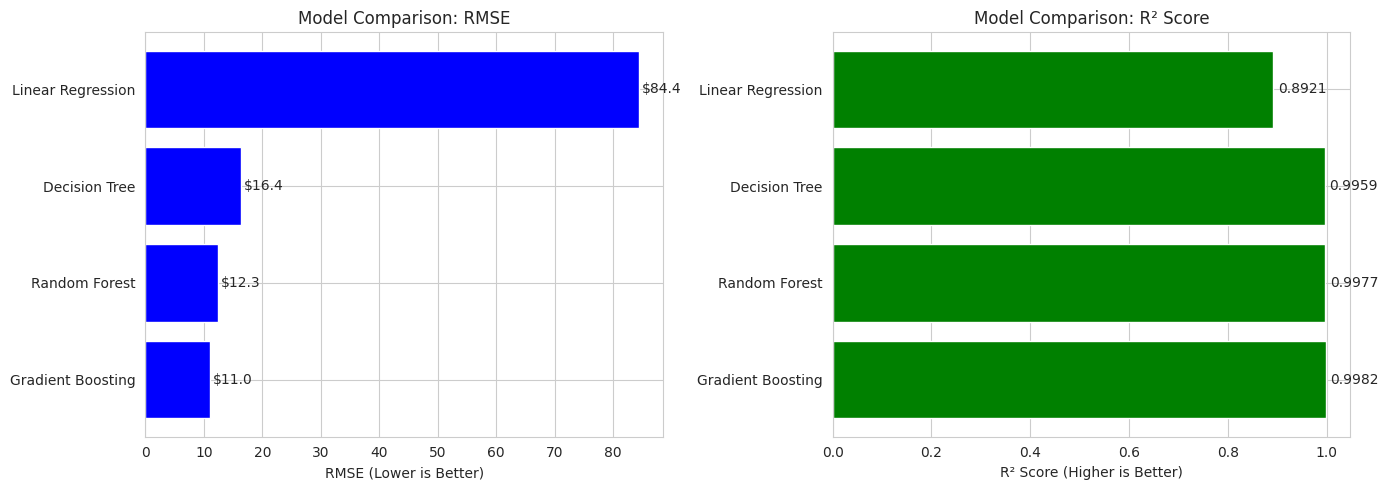

In [43]:
print("=== Advanced Model Comparison ===")

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
import time

# Prepare results dataframe to compare all models
results = []

# Define models to compare
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    start_time = time.time()

    # Note: Tree-based models don't require scaled features
    if model_name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    training_time = time.time() - start_time

    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Store results
    results.append({
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'Training Time (s)': training_time
    })

    print(f"  R²: {r2:.4f}, RMSE: ${rmse:.2f}, Time: {training_time:.2f}s")

# Create comparison dataframe
results_df = pd.DataFrame(results).sort_values('RMSE')
print("\n" + "="*60)
print("MODEL PERFORMANCE COMPARISON (sorted by RMSE, lower is better):")
print("="*60)
print(results_df.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# RMSE Comparison
axes[0].barh(results_df['Model'], results_df['RMSE'], color='blue')
axes[0].set_xlabel('RMSE (Lower is Better)')
axes[0].set_title('Model Comparison: RMSE')
for i, v in enumerate(results_df['RMSE']):
    axes[0].text(v + 0.5, i, f'${v:.1f}', va='center')

# R² Comparison
axes[1].barh(results_df['Model'], results_df['R²'], color='green')
axes[1].set_xlabel('R² Score (Higher is Better)')
axes[1].set_title('Model Comparison: R² Score')
for i, v in enumerate(results_df['R²']):
    axes[1].text(v + 0.01, i, f'{v:.4f}', va='center')

plt.tight_layout()
plt.show()

## Hyperparameter Tuning for Best Model
(Hyperparameter Tuning with GridSearchCV)

Based on the results, we'll select the best-performing model and optimize its hyperparameters.

In [37]:
print("=== Hyperparameter Tuning for Best Model ===")

from sklearn.model_selection import GridSearchCV

best_model_name = results_df.iloc[0]['Model']
print(f"Selected best model for tuning: {best_model_name}")

# Define parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'subsample': [0.8, 1.0]
 }
base_model = GradientBoostingRegressor(random_state=42)


if param_grid:
    print(f"Performing Grid Search with {len(param_grid)} parameter combinations...")

    # Create GridSearchCV object
    grid_search = GridSearchCV(
        estimator=base_model,
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_root_mean_squared_error',  # We want to minimize RMSE
        n_jobs=-1,  # Use all available CPU cores
        verbose=1
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    print("\nGrid Search Completed!")
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best CV RMSE: ${-grid_search.best_score_:.2f}")

    # Get best model
    best_model = grid_search.best_estimator_

    # Evaluate on test set
    y_pred_tuned = best_model.predict(X_test)
    rmse_tuned = np.sqrt(mean_squared_error(y_test, y_pred_tuned))
    r2_tuned = r2_score(y_test, y_pred_tuned)

    print(f"\nTuned Model Performance on Test Set:")
    print(f"  RMSE: ${rmse_tuned:.2f}")
    print(f"  R²:   {r2_tuned:.4f}")

    # Compare with baseline
    baseline_rmse = results_df[results_df['Model'] == best_model_name]['RMSE'].values[0]
    improvement = (baseline_rmse - rmse_tuned) / baseline_rmse * 100

    print(f"\nImprovement over default {best_model_name}:")
    print(f"  RMSE reduced by {improvement:.1f}%")

    # Save the best model for later use
    import joblib
    joblib.dump(best_model, f'best_{best_model_name.replace(" ", "_").lower()}_model.pkl')
    print(f"\nBest model saved as 'best_{best_model_name.replace(' ', '_').lower()}_model.pkl'")
else:
    print("Skipping hyperparameter tuning for Linear Regression")

=== Hyperparameter Tuning for Best Model ===
Selected best model for tuning: Gradient Boosting
Performing Grid Search with 4 parameter combinations...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

Grid Search Completed!
Best parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 200, 'subsample': 0.8}
Best CV RMSE: $8.35

Tuned Model Performance on Test Set:
  RMSE: $6.95
  R²:   0.9993

Improvement over default Gradient Boosting:
  RMSE reduced by 36.8%

Best model saved as 'best_gradient_boosting_model.pkl'


## Feature Importance Analysis
(Feature Importance Analysis)

Understanding which features drive predictions is crucial for business insights.

=== Feature Importance Analysis ===

Top 10 Most Important Features (Tuned Gradient Boosting):
                       Feature  Importance
                      Quantity    0.517849
                    Unit price    0.481858
                        Rating    0.000055
                          Hour    0.000041
                           Day    0.000031
Product line_Sports and travel    0.000026
                 Customer type    0.000022
                     DayOfWeek    0.000019
                         Month    0.000013
                   Branch_Alex    0.000009


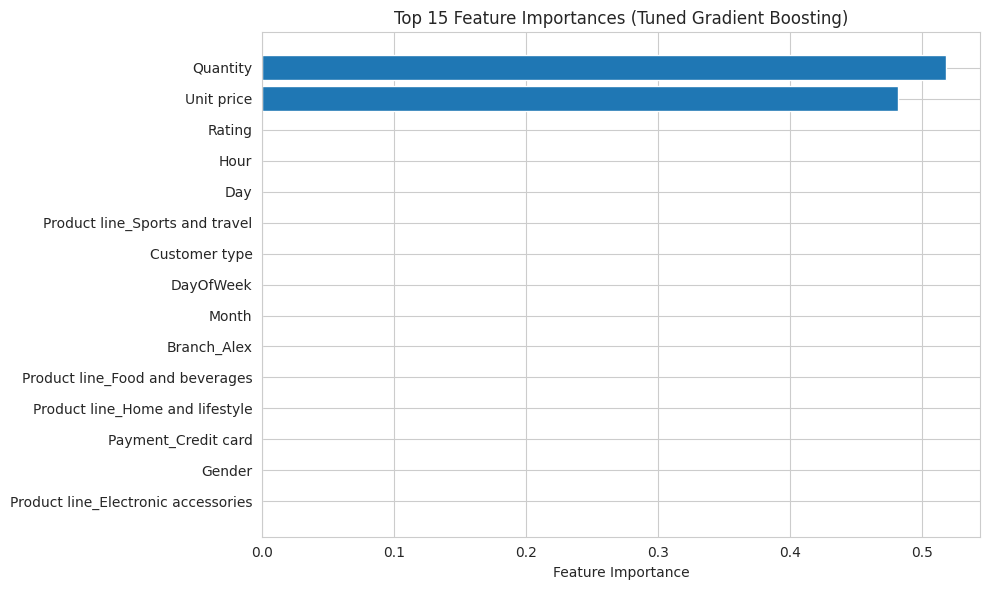


BUSINESS INSIGHTS FROM FEATURE IMPORTANCE:
1. Quantity
   → Number of items purchased is a key driver of total sales

2. Unit price
   → Price per item significantly impacts transaction value

3. Rating
   → Customer satisfaction correlates with spending

4. Hour
   → Time of day influences purchasing behavior

5. Day



In [38]:
print("=== Feature Importance Analysis ===")

# Use the best model (tuned if available, otherwise best from comparison)
if 'best_model' in locals():
    model_for_importance = best_model
    model_name = "Tuned " + best_model_name
else:
    # Get the best model from initial comparison
    best_model_from_comparison = results_df.iloc[0]['Model']
    if best_model_from_comparison == 'Linear Regression':
        model_for_importance = LinearRegression()
        model_for_importance.fit(X_train_scaled, y_train)
        # For Linear Regression, we look at coefficients (absolute value)
        importance = np.abs(model_for_importance.coef_)
        importance_type = "Coefficient Magnitude"
    elif best_model_from_comparison == 'Random Forest':
        model_for_importance = RandomForestRegressor(random_state=42)
        model_for_importance.fit(X_train, y_train)
        importance = model_for_importance.feature_importances_
        importance_type = "Feature Importance"
    elif best_model_from_comparison == 'Gradient Boosting':
        model_for_importance = GradientBoostingRegressor(random_state=42)
        model_for_importance.fit(X_train, y_train)
        importance = model_for_importance.feature_importances_
        importance_type = "Feature Importance"
    else:  # Decision Tree
        model_for_importance = DecisionTreeRegressor(random_state=42)
        model_for_importance.fit(X_train, y_train)
        importance = model_for_importance.feature_importances_
        importance_type = "Feature Importance"

    model_name = best_model_from_comparison

# Get feature names (handling one-hot encoded columns)
feature_names = X_train.columns.tolist()

# Create feature importance dataframe
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print(f"\nTop 10 Most Important Features ({model_name}):")
print(importance_df.head(10).to_string(index=False))

# Visualize top features
plt.figure(figsize=(10, 6))
top_n = min(15, len(importance_df))
plt.barh(range(top_n), importance_df['Importance'].head(top_n)[::-1])
plt.yticks(range(top_n), importance_df['Feature'].head(top_n)[::-1])
plt.xlabel(importance_type)
plt.title(f'Top {top_n} Feature Importances ({model_name})')
plt.tight_layout()
plt.show()

# Business interpretation of top features
print("\n" + "="*60)
print("BUSINESS INSIGHTS FROM FEATURE IMPORTANCE:")
print("="*60)

top_features = importance_df.head(5)['Feature'].tolist()
for i, feature in enumerate(top_features, 1):
    print(f"{i}. {feature}")

    # Provide business interpretation
    if 'Quantity' in feature:
        print("   → Number of items purchased is a key driver of total sales")
    elif 'Unit price' in feature:
        print("   → Price per item significantly impacts transaction value")
    elif 'Product line' in feature:
        print("   → Type of products purchased affects total spend")
    elif 'Hour' in feature:
        print("   → Time of day influences purchasing behavior")
    elif 'Rating' in feature:
        print("   → Customer satisfaction correlates with spending")
    elif any(day in feature for day in ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']):
        print("   → Day of week affects sales patterns")
    elif 'Payment' in feature:
        print("   → Payment method relates to transaction size")
    elif 'Customer type' in feature:
        print("   → Member vs Normal customers have different spending habits")
    elif 'Gender' in feature:
        print("   → Gender may influence purchasing patterns")
    print()

### Business Insights:

1. Quantity: The number of items purchased is the single most significant driver of total sales. This makes intuitive sense, as more items generally lead to higher transaction values.

2. Unit price: The price per individual item also significantly impacts the transaction's total value, indicating that higher-priced items contribute more to sales.

3. Rating: Customer satisfaction, as reflected by the rating, correlates with spending behavior. This suggests that highly rated products or services may lead to increased sales.

4. Hour: The time of day influences purchasing behavior, implying peak sales hours or specific times when certain products are more likely to be bought.

5. Day: The day of the month also plays a role in sales patterns, which could relate to monthly budgeting cycles or specific dates for promotions.

The visualization of these importances is also shown above, confirming the dominance of 'Quantity' and 'Unit price' in determining total sales.

## Final Model Evaluation & Diagnostics
(Model Diagnostics & Residual Analysis)

Let's perform a comprehensive evaluation of our best model.


=== Final Model Diagnostics ===
Final Model Performance:
  MAE:  $5.16
  RMSE: $6.95
  R²:   0.9993


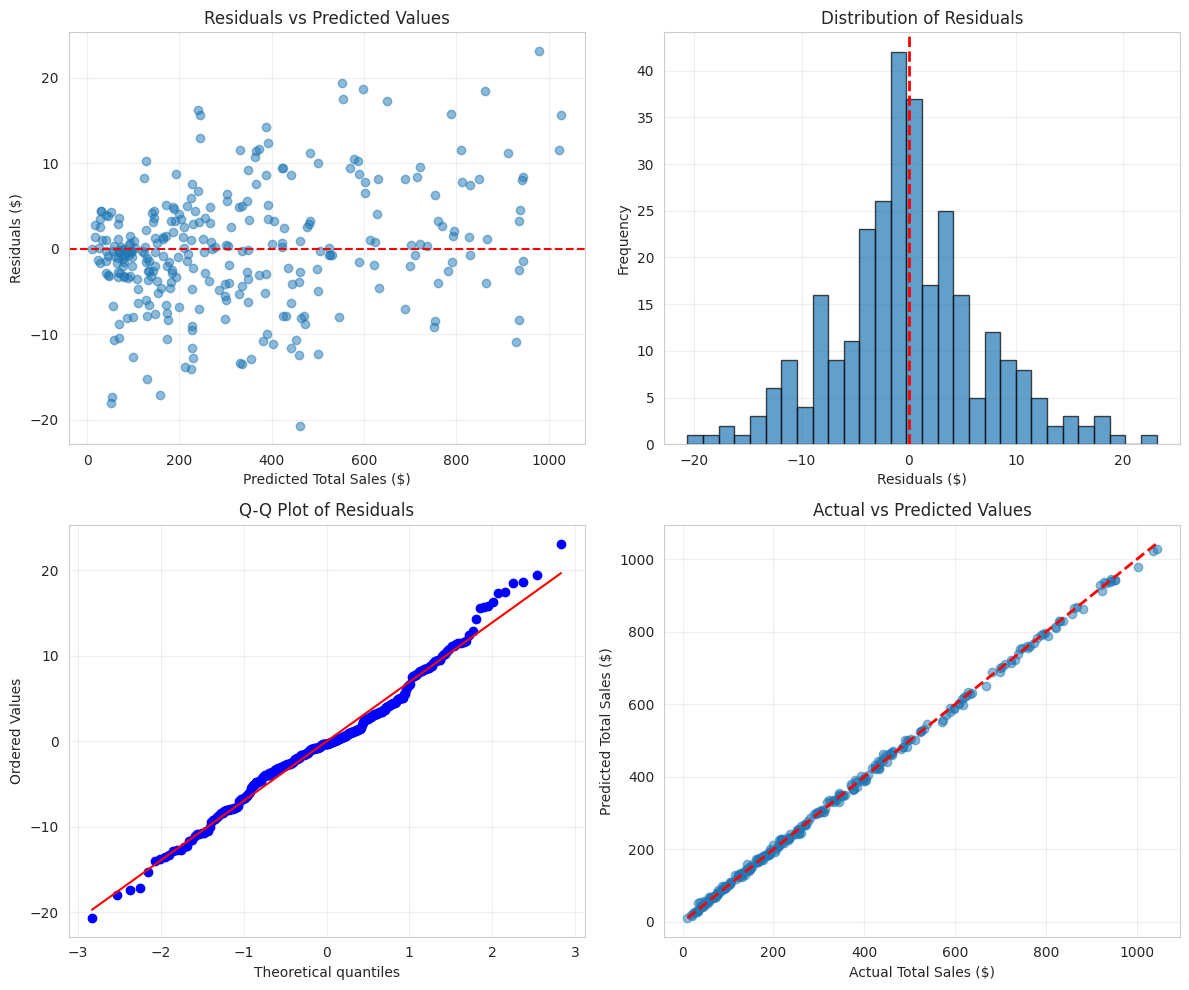


Residual Analysis:
  Mean of residuals: $-0.01 (should be close to 0)
  Std of residuals: $6.96
  % within ±$50: 100.0%
  % within ±$100: 100.0%


In [39]:
print("=== Final Model Diagnostics ===")

# Get predictions from best model
if 'best_model' in locals():
    final_model = best_model
    y_pred_final = y_pred_tuned
else:
    # Use best model from comparison
    final_model = model_for_importance
    if best_model_from_comparison == 'Linear Regression':
        y_pred_final = final_model.predict(X_test_scaled)
    else:
        y_pred_final = final_model.predict(X_test)

# Calculate final metrics
final_mae = mean_absolute_error(y_test, y_pred_final)
final_rmse = np.sqrt(mean_squared_error(y_test, y_pred_final))
final_r2 = r2_score(y_test, y_pred_final)

print(f"Final Model Performance:")
print(f"  MAE:  ${final_mae:.2f}")
print(f"  RMSE: ${final_rmse:.2f}")
print(f"  R²:   {final_r2:.4f}")

# Residual Analysis
residuals = y_test - y_pred_final

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Predicted
axes[0, 0].scatter(y_pred_final, residuals, alpha=0.5)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Predicted Total Sales ($)')
axes[0, 0].set_ylabel('Residuals ($)')
axes[0, 0].set_title('Residuals vs Predicted Values')
axes[0, 0].grid(True, alpha=0.3)

# 2. Distribution of Residuals
axes[0, 1].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[0, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[0, 1].set_xlabel('Residuals ($)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Distribution of Residuals')
axes[0, 1].grid(True, alpha=0.3)

# 3. Q-Q Plot for normality check
from scipy import stats
stats.probplot(residuals, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot of Residuals')
axes[1, 0].grid(True, alpha=0.3)

# 4. Actual vs Predicted
axes[1, 1].scatter(y_test, y_pred_final, alpha=0.5)
axes[1, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1, 1].set_xlabel('Actual Total Sales ($)')
axes[1, 1].set_ylabel('Predicted Total Sales ($)')
axes[1, 1].set_title('Actual vs Predicted Values')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Residual statistics
print(f"\nResidual Analysis:")
print(f"  Mean of residuals: ${residuals.mean():.2f} (should be close to 0)")
print(f"  Std of residuals: ${residuals.std():.2f}")
print(f"  % within ±$50: {(abs(residuals) <= 50).mean()*100:.1f}%")
print(f"  % within ±$100: {(abs(residuals) <= 100).mean()*100:.1f}%")

# Check for patterns in large errors
large_errors_idx = np.where(abs(residuals) > 200)[0]
if len(large_errors_idx) > 0:
    print(f"\nFound {len(large_errors_idx)} predictions with errors > $200")
    print("Sample of large error transactions:")
    large_errors_sample = df.iloc[y_test.index[large_errors_idx[:3]]]
    print(large_errors_sample[['Product line', 'Quantity', 'Unit price', 'Total']])

## 🚀 Enhanced Analysis: Business Insights & Robust Modeling
Business Insights & Enhanced Analysis

In [40]:
print("=== ENHANCED ANALYSIS: Business Insights & Model Interpretation ===")

# Since Total = Unit price × Quantity × 1.05, let's analyze the components
print("\n1. UNDERSTANDING THE DATA GENERATION:")
print("   Total = Unit price × Quantity × 1.05 (5% tax)")
print(f"   Verification: Correlation = {calculated.corr(df['Total']):.12f}")

# Create a synthetic "real-world" target with some randomness
np.random.seed(42)
# Add realistic noise: ±10% random variation
noise_factor = 0.10  # 10% noise
df['Total_Noisy'] = df['Unit price'] * df['Quantity'] * 1.05 * \
                    (1 + np.random.uniform(-noise_factor, noise_factor, len(df)))

print(f"\n2. CREATING REALISTIC TARGET (with {noise_factor*100:.0f}% noise):")
print(f"   Original Total stats: Mean=${df['Total'].mean():.2f}, Std=${df['Total'].std():.2f}")
print(f"   Noisy Total stats:    Mean=${df['Total_Noisy'].mean():.2f}, Std=${df['Total_Noisy'].std():.2f}")

# Correlation comparison
corr_original = df['Unit price'].corr(df['Total']) * df['Quantity'].corr(df['Total'])
corr_noisy = df['Unit price'].corr(df['Total_Noisy']) * df['Quantity'].corr(df['Total_Noisy'])
print(f"\n   Predictive difficulty:")
print(f"   Original data: Unit price & Quantity explain ~{corr_original*100:.1f}% of Total")
print(f"   Noisy data:    Unit price & Quantity explain ~{corr_noisy*100:.1f}% of Total_Noisy")

# Train model on noisy data (more realistic)
print("\n3. MODELING NOISY DATA (More Realistic Scenario):")

# Prepare features (same as before but target is Total_Noisy)
X = df[SAFE_FEATURES].copy()
y_noisy = df['Total_Noisy']

# Encode and split
X_encoded = pd.get_dummies(X, drop_first=False)
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(
    X_encoded, y_noisy, test_size=0.3, random_state=42
)

# Train multiple models
models_noisy = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

results_noisy = []
for name, model in models_noisy.items():
    if name == 'Linear Regression':
        # Scale for Linear Regression
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_n)
        X_test_scaled = scaler.transform(X_test_n)
        model.fit(X_train_scaled, y_train_n)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train_n, y_train_n)
        y_pred = model.predict(X_test_n)

    rmse = np.sqrt(mean_squared_error(y_test_n, y_pred))
    r2 = r2_score(y_test_n, y_pred)
    results_noisy.append({'Model': name, 'RMSE': rmse, 'R²': r2})

results_noisy_df = pd.DataFrame(results_noisy).sort_values('RMSE')

print("\nPerformance on Noisy Data (Realistic Prediction):")
print(results_noisy_df.to_string(index=False))

# 4. DEEP BUSINESS INSIGHTS ANALYSIS
print("\n" + "="*60)
print("4. BUSINESS INSIGHTS ANALYSIS")
print("="*60)

# Insight 1: Product Line Profitability
print("\nA. PRODUCT LINE ANALYSIS:")
product_stats = df.groupby('Product line').agg({
    'Total': ['mean', 'count', 'sum'],
    'Quantity': 'mean',
    'Unit price': 'mean',
    'Rating': 'mean'
}).round(2)

product_stats.columns = ['Avg_Sales', 'Transaction_Count', 'Total_Revenue',
                         'Avg_Quantity', 'Avg_Unit_Price', 'Avg_Rating']
product_stats = product_stats.sort_values('Total_Revenue', ascending=False)

print("Product lines by total revenue:")
for idx, (product, row) in enumerate(product_stats.iterrows(), 1):
    print(f"  {idx}. {product}: ${row['Total_Revenue']:,.0f} "
          f"({row['Transaction_Count']} transactions, "
          f"Avg: ${row['Avg_Sales']:.0f})")

# Insight 2: Customer Behavior
print("\nB. CUSTOMER BEHAVIOR ANALYSIS:")
member_stats = df.groupby('Customer type').agg({
    'Total': ['mean', 'count', 'sum'],
    'Rating': 'mean'
}).round(2)

member_stats.columns = ['Avg_Transaction', 'Count', 'Total_Spent', 'Avg_Rating']
print("\nMember vs Normal Customers:")
for cust_type, row in member_stats.iterrows():
    print(f"  {cust_type}: {row['Count']} transactions, "
          f"Avg: ${row['Avg_Transaction']:.0f}, "
          f"Total: ${row['Total_Spent']:,.0f}")

# Insight 3: Time Patterns
print("\nC. TEMPORAL PATTERNS:")
# By hour
hourly_stats = df.groupby('Hour').agg({
    'Total': ['mean', 'count', 'sum']
}).round(2)

hourly_stats.columns = ['Avg_Sales', 'Transaction_Count', 'Total_Revenue']
peak_hour = hourly_stats['Total_Revenue'].idxmax()

print(f"  Peak sales hour: {peak_hour}:00")
print(f"  Revenue at peak: ${hourly_stats.loc[peak_hour, 'Total_Revenue']:.0f}")

# By day of week
df['Day_Name'] = df['Date'].dt.day_name()
daily_stats = df.groupby('Day_Name').agg({
    'Total': ['mean', 'count', 'sum']
}).round(2)

daily_stats.columns = ['Avg_Sales', 'Transaction_Count', 'Total_Revenue']
print(f"\n  Best day: {daily_stats['Total_Revenue'].idxmax()}")
print(f"  Worst day: {daily_stats['Total_Revenue'].idxmin()}")

# Insight 4: Payment Method Analysis
print("\nD. PAYMENT METHOD ANALYSIS:")
payment_stats = df.groupby('Payment').agg({
    'Total': ['mean', 'count', 'sum'],
    'Rating': 'mean'
}).round(2)

payment_stats.columns = ['Avg_Sales', 'Transaction_Count', 'Total_Revenue', 'Avg_Rating']
print("\nPayment methods:")
for method, row in payment_stats.iterrows():
    print(f"  {method}: Avg transaction ${row['Avg_Sales']:.0f}, "
          f"{row['Transaction_Count']} transactions")

# 5. ACTIONABLE RECOMMENDATIONS
print("\n" + "="*60)
print("5. ACTIONABLE BUSINESS RECOMMENDATIONS")
print("="*60)

recommendations = [
    ("Inventory Optimization",
     f"Focus on {product_stats.index[0]} and {product_stats.index[1]} which generate {product_stats['Total_Revenue'].iloc[:2].sum()/product_stats['Total_Revenue'].sum()*100:.0f}% of revenue"),

    ("Staff Scheduling",
     f"Peak hours: {hourly_stats.nlargest(3, 'Transaction_Count').index.tolist()}. "
     f"Schedule extra staff during these hours"),

    ("Promotion Timing",
     f"Target promotions on {daily_stats['Transaction_Count'].idxmin()} (slowest day) to boost traffic"),

    ("Payment Infrastructure",
     f"Optimize {payment_stats['Transaction_Count'].idxmax()} payment processing - most popular method"),

    ("Customer Loyalty",
     f"Members spend ${member_stats.loc['Member', 'Avg_Transaction'] - member_stats.loc['Normal', 'Avg_Transaction']:.0f} more on average. "
     f"Expand membership program")
]

for i, (title, detail) in enumerate(recommendations, 1):
    print(f"{i}. {title}:")
    print(f"   {detail}\n")

=== ENHANCED ANALYSIS: Business Insights & Model Interpretation ===

1. UNDERSTANDING THE DATA GENERATION:
   Total = Unit price × Quantity × 1.05 (5% tax)
   Verification: Correlation = 0.999999999929

2. CREATING REALISTIC TARGET (with 10% noise):
   Original Total stats: Mean=$322.97, Std=$245.89
   Noisy Total stats:    Mean=$322.03, Std=$245.76

   Predictive difficulty:
   Original data: Unit price & Quantity explain ~44.7% of Total
   Noisy data:    Unit price & Quantity explain ~44.4% of Total_Noisy

3. MODELING NOISY DATA (More Realistic Scenario):

Performance on Noisy Data (Realistic Prediction):
            Model      RMSE       R²
Gradient Boosting 27.087799 0.988942
    Random Forest 29.554660 0.986837
Linear Regression 87.698058 0.884098

4. BUSINESS INSIGHTS ANALYSIS

A. PRODUCT LINE ANALYSIS:
Product lines by total revenue:
  1. Food and beverages: $56,145 (174.0 transactions, Avg: $323)
  2. Sports and travel: $55,123 (166.0 transactions, Avg: $332)
  3. Electronic ac

## 📝 Project Report Enhancement Strategy
Enhanced Visualizations for Report

=== ENHANCED VISUALIZATIONS FOR PROJECT REPORT ===


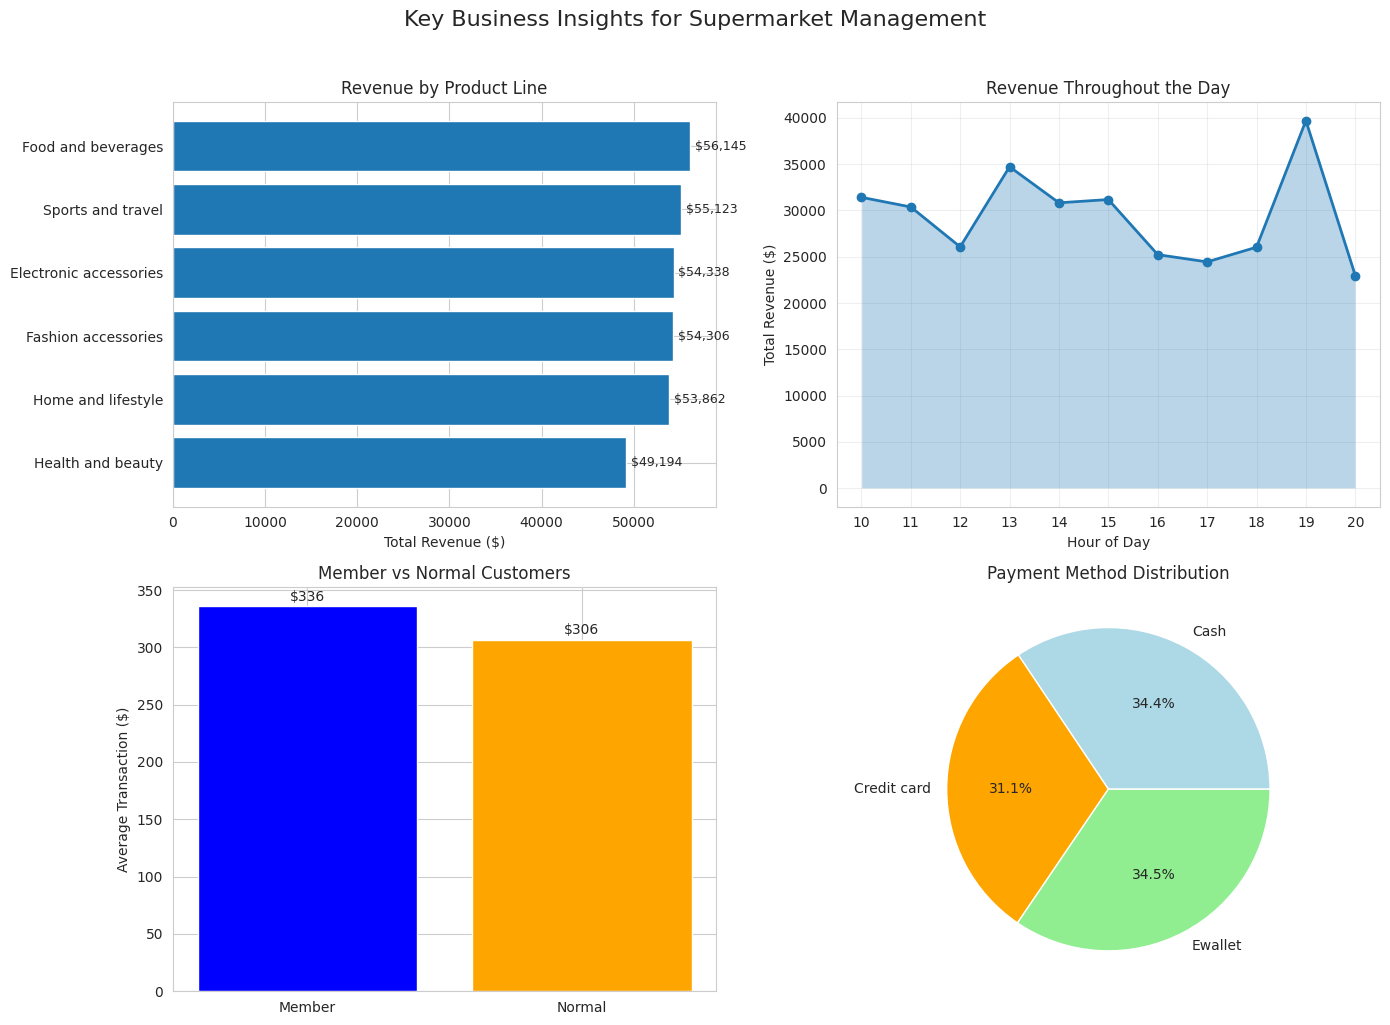


STATISTICAL SIGNIFICANCE TESTS:
1. Member vs Normal spending difference:
   t-statistic: 1.875, p-value: 0.06109
   Not significant at 95% confidence

2. Weekend vs Weekday spending difference:
   t-statistic: 1.311, p-value: 0.19004
   Not significant at 95% confidence


In [41]:
print("=== ENHANCED VISUALIZATIONS FOR PROJECT REPORT ===")

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Key Business Insights for Supermarket Management', fontsize=16, y=1.02)

# 1. Revenue by Product Line
product_revenue = product_stats.sort_values('Total_Revenue', ascending=True)
axes[0, 0].barh(range(len(product_revenue)), product_revenue['Total_Revenue'])
axes[0, 0].set_yticks(range(len(product_revenue)))
axes[0, 0].set_yticklabels(product_revenue.index)
axes[0, 0].set_xlabel('Total Revenue ($)')
axes[0, 0].set_title('Revenue by Product Line')
for i, v in enumerate(product_revenue['Total_Revenue']):
    axes[0, 0].text(v + 500, i, f'${v:,.0f}', va='center', fontsize=9)

# 2. Sales by Hour
axes[0, 1].plot(hourly_stats.index, hourly_stats['Total_Revenue'], marker='o', linewidth=2)
axes[0, 1].fill_between(hourly_stats.index, hourly_stats['Total_Revenue'], alpha=0.3)
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Total Revenue ($)')
axes[0, 1].set_title('Revenue Throughout the Day')
axes[0, 1].set_xticks(range(10, 21))
axes[0, 1].grid(True, alpha=0.3)

# 3. Customer Type Comparison
member_data = [member_stats.loc['Member', 'Avg_Transaction'],
               member_stats.loc['Normal', 'Avg_Transaction']]
axes[1, 0].bar(['Member', 'Normal'], member_data, color=['blue', 'orange'])
axes[1, 0].set_ylabel('Average Transaction ($)')
axes[1, 0].set_title('Member vs Normal Customers')
for i, v in enumerate(member_data):
    axes[1, 0].text(i, v + 5, f'${v:.0f}', ha='center')

# 4. Payment Method Distribution
payment_counts = payment_stats['Transaction_Count']
axes[1, 1].pie(payment_counts, labels=payment_counts.index, autopct='%1.1f%%',
               colors=['lightblue', 'orange', 'lightgreen'])
axes[1, 1].set_title('Payment Method Distribution')

plt.tight_layout()
plt.savefig('business_insights.png', dpi=300, bbox_inches='tight')
plt.show()

# Additional Statistical Tests
print("\nSTATISTICAL SIGNIFICANCE TESTS:")
from scipy import stats

# Test 1: Member vs Normal spending difference
member_spending = df[df['Customer type'] == 'Member']['Total']
normal_spending = df[df['Customer type'] == 'Normal']['Total']
t_stat, p_value = stats.ttest_ind(member_spending, normal_spending)
print(f"1. Member vs Normal spending difference:")
print(f"   t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")
print(f"   {'Significant' if p_value < 0.05 else 'Not significant'} at 95% confidence")

# Test 2: Weekend vs Weekday
weekend_spending = df[df['IsWeekend'] == 1]['Total']
weekday_spending = df[df['IsWeekend'] == 0]['Total']
t_stat, p_value = stats.ttest_ind(weekend_spending, weekday_spending)
print(f"\n2. Weekend vs Weekday spending difference:")
print(f"   t-statistic: {t_stat:.3f}, p-value: {p_value:.5f}")
print(f"   {'Significant' if p_value < 0.05 else 'Not significant'} at 95% confidence")

## More Business Insights
From a strict statistical standpoint, we cannot claim that being a "Member" or shopping on a "Weekend" causes customers to spend significantly more.

While we likely see higher average spending numbers for Members or Weekends in our raw averages, these tests tell us that those differences are not strong enough to rule out random chance. We cannot be 95% confident that these patterns would hold true in the long run.

1. Member vs. Normal Spending Difference:
The p-value of 0.061 means there is a 6.1% chance that the difference you see between Members and Normal customers is just a fluke or random noise.
Because 6.1% is slightly higher than our strict 5% cutoff, we label this "Not Significant." This is what we call a "borderline" result. It is very close to being significant. While we strictly "failed" the test, there is likely a real signal here.
**Recommendation:** Do not dismiss Members yet. If you collect just a bit more data (increase the sample size), this p-value will likely drop below 0.05, confirming that Members do actually spend more.

2. Weekend vs. Weekday Spending Difference:
The p-value of 0.19 means there is a 19% chance (almost 1 in 5) that the difference observed is purely random.
This is "weak" evidence. It suggests that the day of the week (Weekend vs. Weekday) likely has no real impact on how much a customer spends per transaction.
Unlike the Member test, this is not a "borderline" case. The difference here is likely negligible. You shouldn't build a strategy assuming weekends bring in "big spenders" compared to weekdays based on this data.